In [2]:


import sys 
import matplotlib.pyplot as plt
import numpy as np 
from numpy import sin, cos
from math import atan2
from pydot import graph_from_dot_data

sys.path.append("../")


from pydrake.common.value import Value
from pydrake.geometry import StartMeshcat, MeshcatVisualizer
from pydrake.systems.framework import DiagramBuilder, LeafSystem, BasicVector, Context, ContinuousState
from pydrake.multibody.math import SpatialForce
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph, ExternallyAppliedSpatialForce, ExternallyAppliedSpatialForceMultiplexer, AddMultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.systems.analysis import Simulator
from pydrake.math import inv
from pydrake.all import AbstractValue, LogVectorOutput,  JacobianWrtVariable


from src.LauncherFunct.PlanarPRR_launcher import PlanarPRR_Controller
from src.plant.PRR import PlanarPRR
from src.controller.CartesianContrellerEE import CartesianController

from manipulation.scenarios import AddMultibodyTriad


Simulation of a planar PPR without input decoupling, pure dynamic system 

In [3]:
class PlanarPPR(LeafSystem):

    def __init__(self):

        LeafSystem.__init__(self)

        self.M = np.zeros((3, 3))
        self.C = np.zeros((3))
        self.ActuationMatrix = np.zeros((3, 2))
        self.Jac = np.zeros((3, 3))

        group_index = self.DeclareContinuousState(6)

        self.DeclareVectorInputPort("F", BasicVector(2))
        self.DeclareStateOutputPort("state", group_index)
        
        self.init_dynamic_model_parameters()

    def DoCalcTimeDerivatives(self, context:Context, derivatives_out:ContinuousState):

        fx, fy = self.get_input_port(0).Eval(context)
        F = np.array([fx, fy])
        state = context.get_continuous_state_vector()

        # test on fixing joint limit. Still to do: this next lines doesn't work
        #dq1 = min(max(state[3], -self.limit_q1), self.limit_q1)
        #dq2 = min(max(state[4], -self.limit_q2), self.limit_q2)
        #dq3 = min(max(state[5], -self.limit_q3), self.limit_q3)

        dq1, dq2, dq3 = state[3], state[4], state[5]
        self.eval_dyn_model(state_vect=state)
        q_dot = np.array([dq1, dq2, dq3])
        q_dot_dot = np.linalg.inv(self.M) @ ((self.ActuationMatrix @ F) - self.C)
        derivatives = np.concatenate( (q_dot, q_dot_dot) )
        derivatives_out.get_mutable_vector().SetFromVector(derivatives)

    def init_dynamic_model_parameters(self):

        self.m = [1, 1, 1]
        self.I = [1, 1, 1]
        self.d = [None, None, 0.5]
        self.l = [None, None, 1]  # the first is none because is q1
        
        self.a1 = self.m[0] + self.m[1] + self.m[2]
        self.a2 = self.m[1] + self.m[2] 
        self.a3 = self.I[2] + self.m[2] * (self.d[2]**2)
        self.a4 = self.m[2] * self.d[2]

    def eval_dyn_model(self, state_vect):
        self._eval_M_of_q(state_vect)
        self._eval_C_of_q(state_vect)
        self._eval_actuation_matrix(state_vect)

    def _eval_M_of_q(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]
        
        self.M[0, 0] =  self.a1
        self.M[0, 1] = 0
        self.M[0, 2] = 0

        self.M[1, 0] = 0
        self.M[1, 1] = self.a2
        self.M[1, 2] = -self.a4 * sin(q3) 

        self.M[2, 0] = 0
        self.M[2, 1] = -self.a4 * sin(q3)
        self.M[2, 2] = self.a3

    def _eval_C_of_q(self, state_vect):
      
        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]
        dq1, dq2, dq3 = state_vect[3], state_vect[4], state_vect[5]

        self.C[0] = -self.a4*(dq3**2)*sin(q3)
        self.C[1] = -self.a4*(dq3**2)*cos(q3)
        self.C[2] = 0

    def _eval_actuation_matrix(self, state_vect):
        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]

        self.ActuationMatrix[0, 0]  = 0
        self.ActuationMatrix[0, 1]  = 1 
        
        self.ActuationMatrix[1, 0] = 1
        self.ActuationMatrix[1, 1] = 0
        
        self.ActuationMatrix[2, 0] = -self.l[2]*sin(q3)
        self.ActuationMatrix[2, 1] = self.l[2] * cos(q3)



PlanarPPR()

In [3]:
class Mapping_ee(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorOutputPort('EE_state', BasicVector(4), self.CalcEEPosit)
        self.DeclareVectorInputPort('q_vect', BasicVector(6))


    def CalcEEPosit(self, context, EE_posit):

        state = self.get_input_port().Eval(context)
        q1, q2, q3 = state[0], state[1], state[2]
        dq1, dq2, dq3 = state[3], state[4], state[5]
        j = np.zeros((2, 3))
        
        j[0, 0] = 0
        j[0, 1] = 1 
        j[0, 2] = -sin(q3)
        j[1, 0] = 1
        j[1, 1] = 0
        j[1, 2] = cos(q3)
        
        xy_dot = j@np.array([dq1, dq2, dq3])

        x = q2 + sin(q3)
        y = q1 + cos(q3)

        EE_posit.SetFromVector(np.array([x, y, xy_dot[0], xy_dot[1]]))
        


    

In [4]:

builder = DiagramBuilder()

PPR = builder.AddSystem(PlanarPPR())
controller = builder.AddSystem(CartesianController())
mapping = builder.AddSystem(Mapping_ee())

builder.Connect(PPR.get_output_port(), mapping.get_input_port())
builder.Connect(mapping.get_output_port(), controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port(), PPR.get_input_port())


diagram = builder.Build()
context = diagram.CreateDefaultContext()
PPR_context = PPR.GetMyContextFromRoot(context)
controller_context = controller.GetMyMutableContextFromRoot(context)

PPR_context.SetContinuousState(np.array([0, 0, 0, 0, 0, 0]))
controller.get_input_port_desired_state().FixValue(controller_context, np.array([2, 1, 0, 0]))

sim = Simulator(diagram, context)
sim.AdvanceTo(50.0)





Planar with sdf and multibody 

In [47]:
class SimpleDiscreteTimeSystem(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareDiscreteState(6)  # One state variable.
        self.DeclareStateOutputPort("theta", state_index)  # One output: y=x.
        self.DeclarePeriodicPublishEvent
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=1.0,  # One second time step.
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.

    # x[n+1] = x^3[n]
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().GetAtIndex(0)
        x_next = x**3
        discrete_state.get_mutable_vector().SetAtIndex(0, x_next)

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [117]:
from pydrake.systems.framework import Context, ContinuousState


class mapped_system(LeafSystem):

    def __init__(self, plant):
        
        LeafSystem.__init__(self)
        self.EEcounter = 0
        self.theta_counter = 0
        self.plant = plant
        self.plant_context = plant.CreateDefaultContext()
        self.M = np.zeros((3, 3))
        self.C = np.zeros(3)
        self.jac = np.zeros((2, 3)) # used as actuation matrix 
        
        self.jac_h = np.zeros((3, 3))
        self.jac_h_dot = np.zeros((3, 3))

        self.DeclareContinuousState(6) #theta
        self.DeclareVectorInputPort('Q', BasicVector(6))
        self.DeclareVectorInputPort("F", BasicVector(2))
        self.DeclareVectorOutputPort("EE_posit", BasicVector(2), self.CalcEEPosition)

    def eval_dyn(self, state_q):
        self.plant_context.SetDiscreteState(state_q)

        self._eval_jac()
        self._eval_C()
        self._eval_M()

        self._eval_jac_h()
        self._eval_jac_h_dot(state_q[-1])

    def _eval_jac(self):
        j = self.plant.CalcJacobianPositionVector(self.plant_context,
                                        self.plant.GetBodyByName('l3').body_frame(), 
                                        np.array([0, 0, 0.25]),
                                        self.plant.world_frame(),
                                        self.plant.world_frame())
        self.jac = j[:2, :] # select only x,y component, angular
    
    def _eval_jac_h_dot(self, q3dot):
        # i'm able to find a cool way for automatic differentiation, so i decide to just calc analytically
        self.jac_h_dot[0, 2] = -self.jac_h[1, 2]*(q3dot)
        self.jac_h_dot[1, 2] = self.jac_h[0, 2]*(q3dot) 
 
    def _eval_jac_h(self):
        self.jac_h[:2, :] = self.jac
        self.jac_h[2, 2] = 1

    def _eval_M(self):
        self.M = self.plant.CalcMassMatrix(self.plant_context)

    def _eval_C(self):
        self.C = self.plant.CalcBiasTerm(self.plant_context)

    def DoCalcTimeDerivatives(self, context, next_state):

        state_theta = context.get_continuous_state_vector()
        theta_dot = np.array([state_theta[3], state_theta[4], state_theta[5]])

        state_q = self.GetInputPort('Q').Eval(context)
        F = self.GetInputPort("F").Eval(context)      
        self.eval_dyn(state_q)

        inv_jac_h = inv(self.jac_h)
        M_of_theta = inv_jac_h.T @ self.M @ inv_jac_h

        theta_dot_new = theta_dot
        theta_dotdot_new = inv(M_of_theta)@(self.jac.T @ F) + (self.jac_h_dot @ inv_jac_h @ theta_dot) + self.C

        next_state.get_mutable_vector().SetFromVector(np.concatenate((theta_dot_new, theta_dotdot_new)))


    def CalcEEPosition(self, context, EE_position): 
        state_theta = context.get_continuous_state_vector()
        EE_position.SetFromVector(np.array([state_theta[0], state_theta[1]]))
        self.EEcounter = self.EEcounter + 1



In [134]:
def forward_kin(state):
    x = state[1] + 0.5*cos(state[2])
    y = state[0] + 0.5*sin(state[2])
    theta3 = state[2]
    return np.array([x, y, theta3, 0, 0, 0])


In [162]:
meshcat.Delete()

builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-3)
Parser(plant, scene_graph).AddModels("../sdf_model/PPR_planar.sdf")
plant.Finalize()

mapping = builder.AddSystem(mapped_system(plant))


#BODY_NAMES = ['l1', 'l2', 'l3']
#for body_name in BODY_NAMES:
#    AddMultibodyTriad(plant.GetFrameByName(body_name), scene_graph)

visualizer = MeshcatVisualizer.AddToBuilder(
    builder,
    scene_graph.get_query_output_port(),
    meshcat
    )

builder.Connect(plant.GetOutputPort('state'), mapping.GetInputPort("Q"))
#builder.Connect(controller.GetOutPort('F_2d'), mapping.GetInputPort("F"))
#builder.Connect() # actuation port on plant

logger_controller = LogVectorOutput(mapping.GetOutputPort("EE_posit"), builder)


diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
mapping_context = mapping.GetMyMutableContextFromRoot(context)

starting_condition = np.array([0, 0, 0, 0, 0, 0])

plant_context.SetDiscreteState(starting_condition)
mapping.plant_context.SetDiscreteState(starting_condition)
mapping_context.SetContinuousState(forward_kin(starting_condition))


plant.GetInputPort('actuation').FixValue(plant_context, [0.1, 0.1, 0.1])
mapping.GetInputPort("F").FixValue(mapping_context, np.zeros(2))


diagram.ForcedPublish(context)

In [163]:
sim = Simulator(diagram, context)
sim.AdvanceTo(10)

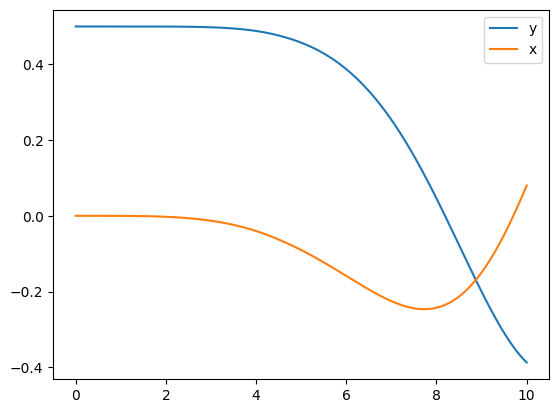

In [164]:
log_EE = logger_controller.FindLog(context)
time_vect = log_EE.sample_times()
plt.plot(time_vect, log_EE.data()[0].transpose(), label='y')
plt.plot(time_vect, log_EE.data()[1].transpose(), label='x')
plt.legend()

In [116]:
print(plant_context)

::_::plant Context
-------------------
Time: 1
States:
  1 discrete state groups with
     6 states
       0.01253591319763351    0.02467209943311 0.04408892272175447 0.02504405037279153 0.04953736901603307 0.08817943719976788

Parameters:
  17 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
       1 0 0 0 1 1 1 0 0 0
     10 parameters
       1 0 0 0 1 1 1 0 0 0
     10 parameters
       1 0 0 0 1 1 1 0 0 0
     12 parameters
                           1                     0                     0                     0 9.632679474769201e-05    0.9999999953605743                     0   -0.9999999953605743 9.632679474769201e-05                     0                     0                     0
     12 parameters
                           1                     0

In [115]:
print(mapping.plant_context)

::plant Context
----------------
Time: 0
States:
  1 discrete state groups with
     6 states
       0.01253591319763351    0.02467209943311 0.04408892272175447 0.02504405037279153 0.04953736901603307 0.08817943719976788

Parameters:
  17 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
       1 0 0 0 1 1 1 0 0 0
     10 parameters
       1 0 0 0 1 1 1 0 0 0
     10 parameters
       1 0 0 0 1 1 1 0 0 0
     12 parameters
                           1                     0                     0                     0 9.632679474769201e-05    0.9999999953605743                     0   -0.9999999953605743 9.632679474769201e-05                     0                     0                     0
     12 parameters
                           1                     0      

In [104]:
np.set_printoptions(precision=10, suppress=True)
M = plant.CalcMassMatrix(plant_context)
print(M)

[[ 3.            0.0001926536 -0.0000240817]
 [ 0.0001926536  2.           -0.25        ]
 [-0.0000240817 -0.25          1.0625      ]]


In [55]:
plant.GetOutputPort('state').Eval(plant_context)

array([0., 0., 0., 0., 0., 0.])

In [43]:
robot = PlanarPPR()
state_vect = np.zeros(6)
robot._eval_M_of_q(state_vect)
robot.eval_C_of_q(state_vect)
robot.M, robot.C

(array([[ 3.  ,  0.  ,  0.  ],
        [ 0.  ,  2.  , -0.  ],
        [ 0.  , -0.  ,  1.25]]),
 array([-0., -0.,  0.]))

In [51]:
randomControll(PlanarPPR)
